In [1]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix
import math

from imblearn.over_sampling import RandomOverSampler

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from sklearn.manifold import TSNE

import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
path = r"C:\Users\Abhishek\bbc-text.csv"

#  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv 

# Read the file
def read_data(path):
    df = pd.read_csv(path, low_memory = False)
    df = df.reset_index(drop = True) 
    return df.sample(frac = 0.20)

df = read_data(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445 entries, 1665 to 666
Data columns (total 2 columns):
category    445 non-null object
text        445 non-null object
dtypes: object(2)
memory usage: 10.4+ KB


In [3]:
df = df[['category', "text"]]
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445 entries, 1665 to 666
Data columns (total 2 columns):
category    445 non-null object
text        445 non-null object
dtypes: object(2)
memory usage: 10.4+ KB


In [4]:
df["category"].value_counts()

sport            110
business          93
tech              82
politics          81
entertainment     79
Name: category, dtype: int64

In [5]:
%%time

def undersample(dataframe, column, basis_col, count, sample_count):
    """
    input:
    dataframe: The dataframe to be sampled(Pandas DataFrame)
    column: The column name based on which sampling is performed(String)
    basis_col : Column using which stratified sampling is applied. Info will be retained even after undersampling.
    count: The value count of individual data points inside the column under
    consideration used as threshold (above which the rows will be discarded).
    sample_count: The final sampled data count needed
    output: Sampled Pandas DataDrame
    Eg. undersample(df, "TD", 1000, 200) # (DataFrame, column name, value_count threshold, sampled count)
    """
    above = pd.DataFrame()
    below = pd.DataFrame()
    data = pd.DataFrame()
    df = dataframe
    col = column
    
    max_val = df[basis_col].value_counts().head(1).values[0]
    n = min(max_val, df[basis_col].value_counts().min())
    stratified = df.groupby(basis_col).apply(lambda x: x.sample(n))
    stratified.index = stratified.index.droplevel(0)
    
    above_count = pd.DataFrame(df[col].value_counts() > count)
    below_count = pd.DataFrame(df[col].value_counts() < count)
    
    to_sample = above_count[above_count[col] == True].index.tolist()
    not_sample = below_count[below_count[col] == True].index.tolist()
    
    for val in to_sample: # Sample with the given sample_count value 
        above = above.append(df[df[col] == val].sample(n = sample_count, 
                                                       replace = True ,
                                                       random_state=1))
    
    for val in not_sample:
        below = below.append(df[df[col] == val]) # Without Sampling for values less than given count
        
    data = pd.concat([above, stratified, below])
    return data


#df = undersample(df, 'category', "text", 5000, 5000)

#df["Product"].value_counts()

Wall time: 0 ns


In [10]:
%%time

def oversample(df, column, other_col, threshold):
    
    """
    input:
    dataframe: The dataframe to be sampled(Pandas DataFrame)
    column: The column name based on which sampling is performed(String)
    other_column: The column name excluding the main column used for sampling(String)
    threshold: the count value above which data needs to be sampled
    output: Sampled Pandas DataDrame
    Eg. oversample(df, "Height", ["Age", "Gender"], 200) # (DataFrame, column, other_col, threshold)
    
    """
    
    df_maj = pd.DataFrame(df.groupby(column).size() >= threshold, columns= ['Values'])
    
    maj_cols = []
    for val in df_maj[df_maj['Values'] == True].index.astype(str):
        maj_cols.append(val)
        
    df_maj = df[df[column].to_frame().isin(maj_cols).all(axis=1)] 
    
    
    df_min = pd.DataFrame(df.groupby(column).size() < threshold, columns= ['Values'])
    
    min_cols = []
    for val in df_min[df_min['Values'] == True].index.astype(str):
        min_cols.append(val)
    df_min = df[df[column].to_frame().isin(min_cols).all(axis=1)] 
    
    selected_col_df_min = other_col
    
    ros = RandomOverSampler(random_state=0)
    
    X_resampled, y_resampled = ros.fit_resample(df_min[selected_col_df_min],df_min[column])

    
    y_resampled_df = pd.DataFrame(y_resampled)
    
    df_min_oversampled = pd.concat([X_resampled, y_resampled_df], axis=1)
    
    df_oversampled = pd.concat([df_maj, df_min_oversampled], sort=False)
    
    return (df_oversampled)

#df = oversample(df, 'category', ["text"], 100)

#df["Product"].value_counts()

Wall time: 0 ns


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445 entries, 1665 to 666
Data columns (total 2 columns):
category    445 non-null object
text        445 non-null object
dtypes: object(2)
memory usage: 10.4+ KB


In [12]:
%%time

def clean_text(text):

    # Remove punctuation
    text = str(text)
    text = text.translate(string.punctuation)
    
    # Convert words to lower case and split them
    text = text.lower().split()
    
    # Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text

df['text'] = df['text'].map(lambda x: clean_text(x))
df['text'].head(10)

Wall time: 1.28 s


1665    hamm bow women footbal legend mia hamm play fi...
1518    job growth still slow creat fewer job expect j...
1120    blair congratul bush win toni blair said look ...
1548    usher lead soul train shortlist chart - top r ...
1621    bookmak back aviat oscar aviat tip bookmak fav...
54      rover reject third ferguson bid blackburn reje...
1869    ferrero eye return top form former world numbe...
1099    everton weir cool euro hope everton defend dav...
249     keanu reev given hollywood star actor keanu re...
1741    state act stop spammer state texa file lawsuit...
Name: text, dtype: object

In [14]:
max_len = []
for item in df['text']:
    max_len.append(len(item))
    
max_length = max(max_len)
max_length

7127

In [16]:
# Create sequence

from sklearn.model_selection import train_test_split

labels = ['text']
target = "category"

classes = df[target].unique()
print(classes)

from sklearn.preprocessing import LabelEncoder

global lb
lb = LabelEncoder()
y1 = df[target].values.tolist()
lb.fit(y1)
y = lb.transform(y1)

from keras.utils import to_categorical
y = to_categorical(y)

vocabulary_size = 3000

tokenizer = Tokenizer(num_words= vocabulary_size)

tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen = max_length+1)
print()

print(X[1:2])

global X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 0)
    
print()
print("The shape of X_train data is :",X_train.shape)
print("The shape of X_test data is :",X_test.shape)
print("The shape of y_train data is :",y_train.shape)
print("The shape of y_test data is :",y_test.shape)

['sport' 'business' 'politics' 'entertainment' 'tech']

[[   0    0    0 ...    7  628 1003]]

The shape of X_train data is : (311, 7128)
The shape of X_test data is : (134, 7128)
The shape of y_train data is : (311, 5)
The shape of y_test data is : (134, 5)


In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os 

save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'consumer_nn_model.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
filepath = os.path.join(save_dir,model_name)
print(filepath)

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)

early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=0, mode='auto')
callbacks = [checkpoint, early_stopping]

C:\Users\Abhishek\saved_model\consumer_nn_model.h5


In [18]:
def plot_loss(history):
    print(history.history.keys())
    
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()




Train on 311 samples, validate on 134 samples
Epoch 1/30
311/311 [==============================] - 71s 229ms/step - loss: 1.6106 - accuracy: 0.2251 - val_loss: 1.5952 - val_accuracy: 0.2463

Epoch 00001: val_loss improved from inf to 1.59519, saving model to C:\Users\Abhishek\saved_model\consumer_nn_model.h5
Epoch 2/30
311/311 [==============================] - 74s 238ms/step - loss: 1.5816 - accuracy: 0.2476 - val_loss: 1.5730 - val_accuracy: 0.2463

Epoch 00002: val_loss improved from 1.59519 to 1.57296, saving model to C:\Users\Abhishek\saved_model\consumer_nn_model.h5
Epoch 3/30
311/311 [==============================] - 74s 238ms/step - loss: 1.5758 - accuracy: 0.3215 - val_loss: 1.5559 - val_accuracy: 0.2537

Epoch 00003: val_loss improved from 1.57296 to 1.55588, saving model to C:\Users\Abhishek\saved_model\consumer_nn_model.h5
Epoch 4/30
311/311 [==============================] - 74s 238ms/step - loss: 1.4803 - accuracy: 0.4051 - val_loss: 1.4701 - val_accuracy: 0.4627

Epo

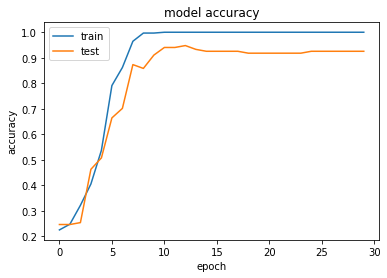

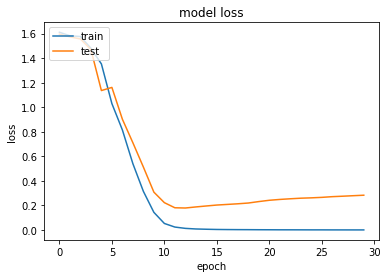

Wall time: 40min 45s


In [19]:
%%time
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length = max_length+1))
    model_conv.add(Dropout(0.25))
    model_conv.add(Conv1D(64, 3, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(256))
    model_conv.add(Dropout(0.25))
    model_conv.add(Dense(len(classes), activation='softmax'))
    model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_conv

model_conv = create_conv_model()
history = model_conv.fit(X_train, y_train, validation_data = (X_test, y_test), 
                         epochs = 30, callbacks = callbacks)

# Summarize history for accuracy
plot_loss(history)

In [20]:
def conf_matrix(y_test, pred, classes, lb):
    
    #cm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
    cm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))

    recall = np.diag(cm) / np.sum(cm, axis = 1) # running horizontally across columns (axis 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0) # running vertically downwards across rows (axis 0)
    
    # Replacing NaN's by 0
    recall = [0 if math.isnan(x) else x for x in recall]
    precision = [0 if math.isnan(x) else x for x in precision]
    
    # Extracting class labels from label binarizer object
    labels = classes
    support = np.sum(cm, axis = 0)

    df_recall = pd.DataFrame(recall, index = labels, columns = ["Recall"])
    df_precision = pd.DataFrame(precision, index = labels, columns = ["Precision"])
    df_support = pd.DataFrame(support, index = labels, columns = ["Support"])
    
    concat = [df_precision, df_recall, df_support]
    acc = pd.concat(concat, axis = 1)

    print(acc)
    print()
    
    tp = sum(np.diag(cm))
    total = sum(cm.flatten())
    accuracy = (tp/total)*100
    print("Accuracy :", accuracy)


In [21]:
pred = model_conv.predict(X_test)
pred[:2]

array([[6.6188333e-04, 1.1090714e-03, 3.4167801e-04, 3.6921888e-03,
        9.9419516e-01],
       [4.6206720e-04, 8.1097858e-07, 4.6985959e-05, 9.9921477e-01,
        2.7544220e-04]], dtype=float32)

In [22]:
conf_matrix(y_test, pred, classes, lb)

               Precision    Recall  Support
sport           0.896552  0.928571       29
business        1.000000  0.916667       22
politics        0.814815  0.916667       27
entertainment   0.941176  0.969697       34
tech            1.000000  0.880000       22

Accuracy : 92.53731343283582


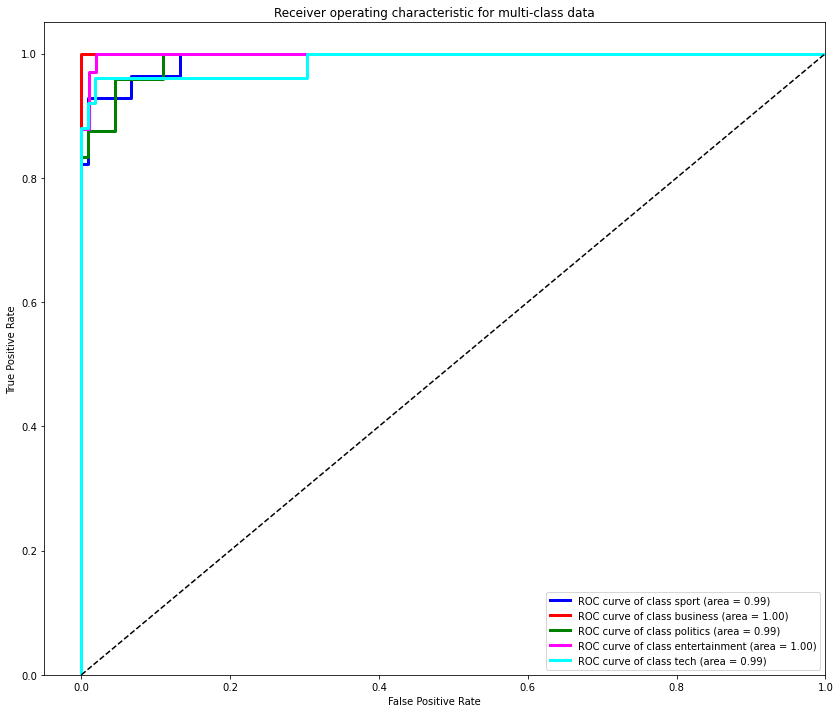

In [25]:
def roc_auc_metric(classes, y_test, predictions):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['blue', 'red', 'green', 'magenta', 'cyan', 'yellow', 'black', 'white', '0.75', '#eeefff', '0.55'])

    plt.figure(figsize=(14,12)) # range(n_classes)
    for i, color, cls in zip(range(n_classes), colors, classes):
        plt.plot(fpr[i], tpr[i], linewidth = 3, color=color, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(cls, roc_auc[i]))


    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

roc_auc_metric(classes, y_test, pred)